In [1]:
import sys
sys.path
sys.executable
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Lambda, Conv2D, \
    MaxPooling2D, UpSampling2D,Input, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from data_utils import *

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [19]:
import skimage, os
from skimage.morphology import ball, disk, dilation,binary_dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing, binary_opening 
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border, mark_boundaries
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.misc
from glob import glob
from skimage.io import imread

In [3]:
class UNet(object):
    def __init__(self, img_shape, num_of_class, actf = 'relu',
        learning_rate = 0.001,  drop_rate = 0.5, do_batch_norm = False, do_drop = False):

        '''
        Arguments :

        img_shape - shape of input image (64, 64, 1)
        actf - activation function for network training
        learning_rate - learning rate for training
        drop_rate - dropout rate
        do_batch_norm - whether to run for batchnormalization
        do_drop - whether to run for dropout
        '''

        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.num_of_class = num_of_class
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()

    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3),
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)

        return pool, conv2

    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):

        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size,
                                                       activation = self.actf, strides = up_conv_strides, kernel_initializer = 'he_normal',
                                                       padding = 'same')(inputs), merge_inputs])

        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # encoder
    def encoding_path(self, inputs):

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)

        return dec_conv4
    # build network
    def build_model(self):
        inputs = Input(self.img_shape)

        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)

        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)

        # Expanding path
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        segmented = Conv2D(self.num_of_class, (1,1), activation ='sigmoid', padding = 'same', kernel_initializer = 'glorot_normal')(dec_path)


        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(lr = self.learning_rate),
                          loss = 'binary_crossentropy', metrics = [dice_coef])

        return model

    # train model
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):

        
        earlystopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
        checkpoint = ModelCheckpoint('checkpoint/model-{epoch:03d}-{val_loss:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min')  
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

        
        self.history = self.model.fit(X_train, Y_train, callbacks=[earlystopping,checkpoint,reduce_lr_loss ], validation_split = val_split,
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history

    # predict test data
    def predict(self, X_test):
        pred_classes = self.model.predict(X_test)

        return pred_classes

    # show u-net architecture
    def show_model(self):
        return print(self.model.summary())



# Segmentation Class U-Net

In [4]:
seg_model = UNet(img_shape = (512,512,1), num_of_class = 1,learning_rate = 1e-5, do_drop = True, drop_rate = 0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [5]:
seg_model.show_model()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Load Model

In [6]:
seg_model.model = keras.models.load_model('checkpoint/model-last.h5', custom_objects={"dice_coef": dice_coef})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
#test run on validation data 

import cv2 

ct_scan_dir = '/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/val/covid/ct_scan_0/'
ct_scan_files = [] 

imgs = [] 
for i in range(150,160):
    fn_full = ct_scan_dir+'{}.jpg'.format(i) 
    img = cv2.imread(fn_full,0) 
    img = np.expand_dims(img,axis=2)
    imgs.append(img)
x_test = np.asarray(imgs) 
print(x_test.shape) 

(10, 512, 512, 1)


In [8]:
preds1 = seg_model.predict(x_test[:5,:,:,:])
preds2 = seg_model.predict(x_test[5:10,:,:,:])
print(preds1.shape)
print(preds2.shape)
preds = np.concatenate((preds1, preds2), axis=0)

(5, 512, 512, 1)
(5, 512, 512, 1)


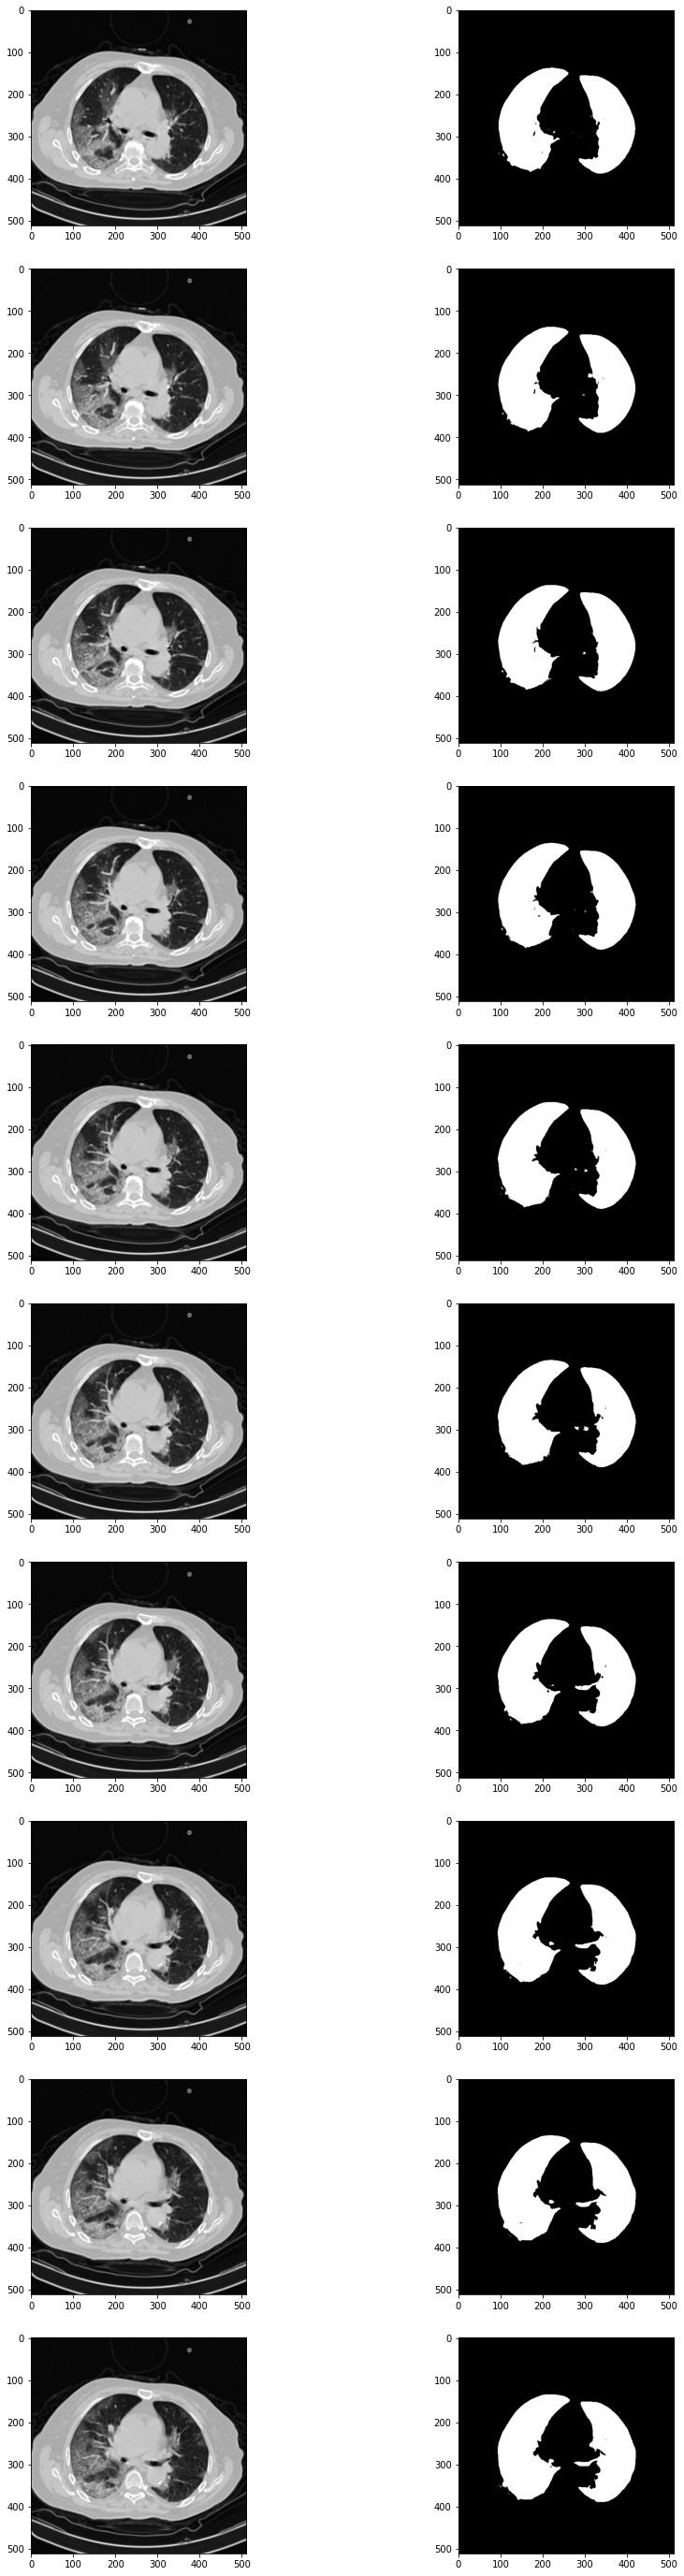

In [9]:
show_num = 10
fig, ax = plt.subplots(show_num, 2, figsize=(15, 50))
for i, pred in enumerate(preds[:show_num]):
    ax[i, 0].imshow(x_test[i].squeeze(), cmap='gray')    
    ax[i, 1].imshow(pred.squeeze(), cmap='gray')

In [10]:
covidx_dir = '/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/'
covidx_img_dir= covidx_dir 
covidx_mask_dir = covidx_dir + 'mask/'

data_list_dir = '/media/ubuntu/MyHDataStor2/products/LateTemporalModeling3DCNN/datasets/settings/covid/'

if not os.path.exists(covidx_mask_dir):
    os.makedirs(covidx_img_dir_cropped)
print(covidx_dir)
print(covidx_img_dir)
print(covidx_mask_dir)
print(data_list_dir)

/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/
/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/
/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/mask/
/media/ubuntu/MyHDataStor2/products/LateTemporalModeling3DCNN/datasets/settings/covid/


In [18]:
#the input mask must be a binary image 
def refine_mask(mask2):

    #mask2 = cv2.imread(m_full, cv2.IMREAD_UNCHANGED)
    #mask2 = (mask2/255).astype(np.uint8) 
    
    selem = disk(10)
    mask2_2  = binary_closing(mask2, selem)                
    label_image = label(mask2_2)
    
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                    label_image[coordinates[0], coordinates[1]] = 0
    mask2_3 = label_image > 0               
    
    edges = roberts(mask2_3) 
    mask2_4 = ndi.binary_fill_holes(edges)
                
    return mask2_4

In [26]:
# for test data only 
from tqdm import tqdm

debug = False 

split = 5 

subset = 'test'
list_file =  data_list_dir + '{}_rgb_split{}.txt'.format(subset,split) 
print(list_file) 

fp = open(list_file)
lines = fp.readlines() 
fp.close()
print(lines[:10])

for l in lines: 

    l_splits = l.split()    
    testset = l_splits[0].split('/')[1]    
    first_slice = int(l_splits[2])
    last_slice = int(l_splits[3])
    
    print(testset,first_slice,last_slice)
    
    for ind in range(first_slice,last_slice+1):
        
        fn = "{}/{}.jpg".format(l_splits[0],ind)        
        f_full = covidx_img_dir + fn 
        fout_full = covidx_mask_dir  + fn +'_refined.jpg' 
        
        fout_dir = os.path.dirname(fout_full)
        if not os.path.exists(fout_dir):
            os.makedirs(fout_dir)
                
        print(f_full)
        print(fout_full)
        
        img = cv2.imread(f_full, cv2.IMREAD_UNCHANGED)
        if img.shape != (512,512):
            img = cv2.resize(img,(512,512)) 
        
        img0 = img 
        
        img = np.expand_dims(img,axis=2)
        img = np.expand_dims(img,axis=0)
        
        mask = seg_model.predict(img)
        mask = mask.squeeze()
        #print(mask.shape)
        
        mask1 = mask > 0.5        
        mask2 = refine_mask(mask1)                
        
        if not os.path.exists(fout_full):
            cv2.imwrite(fout_full, (mask2*255).astype(np.uint8) )
            
            if True: 
                fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(5, 40))
                ax1.imshow(img0,cmap='gray')
                ax2.imshow(mask,cmap='gray')                
                ax3.imshow(mask1,cmap='gray')                
                ax4.imshow(mask2,cmap='gray')
        
        break
    
    
    break
    
    
    
    



/media/ubuntu/MyHDataStor2/products/LateTemporalModeling3DCNN/datasets/settings/covid/test_rgb_split5.txt
['test/subset1/3ea85c05-2cd1-4b5a-822f-3985b0e06867 covid 107 257 34 67 476 387\n', 'test/subset1/2c442cd2-0abd-4ebd-9223-ff7ee8e9953c covid 33 84 5 91 486 418\n', 'test/subset1/3c5a2a48-0a9b-42f1-9e1c-e90fe209d179 covid 20 50 58 141 465 373\n', 'test/subset1/0c000b69-41de-41cd-b498-37d993c94366 covid 48 209 0 123 491 443\n', 'test/subset1/4a81f8d8-e255-44ff-81d1-717868e7b381 covid 53 196 0 16 491 423\n', 'test/subset1/4a1509c1-a588-4f95-a167-96a724f2ce22 covid 100 244 62 178 512 451\n', 'test/subset1/2f9fe28a-9c06-4604-847a-4830163650f6 covid 75 259 101 106 459 399\n', 'test/subset1/03c094cc-b595-4fc9-b21d-66a7d5d7bee9 covid 84 223 0 95 512 450\n', 'test/subset1/2b662269-06f5-4ab6-9f74-4b0f1c30e104 covid 81 205 0 0 512 434\n', 'test/subset1/2ff9dd43-c4b1-4bf5-820b-7f21b895c80c covid 106 183 0 10 512 459\n']
subset1 107 257
/media/ubuntu/MyHDataStor2/datasets/COVID-19/ICCV-MIA/test